In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MinuteLocator, SecondLocator
import numpy as np
import datetime
import os
from omegaconf import OmegaConf, DictConfig, ListConfig

import geopandas as gpd
from shapely.geometry import Point

from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS

from sklearn.metrics.pairwise import haversine_distances

from geopy.distance import great_circle

from shapely.geometry import MultiPoint

from tqdm import tqdm


from hydra import initialize, compose
from omegaconf import OmegaConf

with initialize(version_base=None, config_path="..\\scripts\\config\\"):
    cfg = compose(config_name='config.yaml')

HW CLASSIFICATION

In [778]:
launch_time = "2023-05-13_15-49-08"
cluster_data = pd.read_csv(f"H:\\jupyter\\CityTraffic\\data\\{launch_time}\\clusters_{launch_time}.csv")
df = pd.read_csv(f"H:\\jupyter\\CityTraffic\\data\\{launch_time}\\data_with_clusters_{launch_time}.csv", index_col=0)


In [987]:
id_day_info = df.groupby('id')['log_date'].nunique()
good_id = id_day_info[id_day_info > 10].index
df = df[df['id'].isin(good_id)]
cluster_data = cluster_data[cluster_data['id'].isin(good_id)]

In [986]:
cluster_data.head()

id      lat      lon  cluster  cluster_size           inq wewd_ratio   
0  2.0  54.8436  38.1929      0.0        5056.0  26032.644737   1.111111  \
1  6.0  54.9034  38.0696      0.0         989.0  15146.533333        0.0   
2  6.0  54.8933  38.0780      1.0         830.0  39723.665414   0.208333   
3  8.0  54.8914  38.0634      0.0         569.0      12856.75        0.0   
4  8.0  54.8811  38.0551      1.0         241.0  12940.543478        0.0   

   work_place  class  
0        True      0  
1        True      0  
2       False      0  
3       False      0  
4       False      0

In [780]:
df.head()

lat      lon            ts   id  length  cluster    log_date
0  54.8435  38.1928  1.676952e+09  2.0     0.5        0  2023-02-21
1  54.8435  38.1928  1.676952e+09  2.0     0.5        0  2023-02-21
2  54.8435  38.1928  1.674846e+09  2.0  1005.0        0  2023-01-27
3  54.8435  38.1928  1.674848e+09  2.0  1005.0        0  2023-01-27
4  54.8435  38.1928  1.674849e+09  2.0  1005.0        0  2023-01-27

In [781]:
#only weekday
def sec_from_day_start(x):
    hm = pd.to_datetime(x, unit='s').dt.strftime('%H:%M:%S').str.split(':')
    return hm.apply(lambda x: 3600 * int(x[0]) + 60 * int(x[1]) + int(x[0]))

THRESH_VALUE = cfg.inq_thresh
SEC_IN_DAY = 60 * 60 * 24
A = 20000
B = 60000
DAY_NIGHT_THRESH = 0.33
if 'work_place' in cluster_data.columns:
    cluster_data.drop(columns=['work_place'], inplace=True)
    
cluster_data['inq'] = None
cluster_data['wewd_ratio'] = None

for cur_id in tqdm(df['id'].unique()):
    cur_id_df = df.query('id == @cur_id and cluster != -1').copy()
    cur_id_clusters = cur_id_df['cluster'].unique()

    #weekdays
    wd_data = cur_id_df[pd.to_datetime(cur_id_df['ts'], unit='s').dt.dayofweek < 5].copy()
    cur_id_df['day_ts'] = cur_id_df['ts'] % (SEC_IN_DAY)
    wd_data['day_ts'] = wd_data['ts'] % (SEC_IN_DAY)
    df_gd = cur_id_df.groupby('cluster')
    daytime = df_gd['day_ts'].apply(lambda x: np.sum(x.between(A, B)) / x.shape[0])
    day_clusters = daytime[daytime > DAY_NIGHT_THRESH].index
    night_clusters = daytime[daytime <= DAY_NIGHT_THRESH].index

    #day clusters
    day_gd = wd_data[wd_data['cluster'].isin(day_clusters)].groupby('cluster')
    d_inq = day_gd[['day_ts']].agg(lambda x: np.quantile(x, 0.75)) - day_gd[['day_ts']].agg(lambda x: np.quantile(x, 0.25))
    day_features = pd.DataFrame({'cluster' : day_clusters})
    day_features = day_features.merge(d_inq['day_ts'].rename('inq').reset_index(), on='cluster', how='left')


    #night clusters
    night_data = wd_data[~wd_data['cluster'].isin(day_clusters)]
    n_mask = night_data['day_ts'] < night_data['day_ts'].mean()
    night_data.loc[n_mask, 'day_ts'] = SEC_IN_DAY + night_data['day_ts'][n_mask] 
    night_gd = night_data.groupby('cluster')
    n_inq = night_gd[['day_ts']].agg(lambda x: np.quantile(x, 0.75)) - night_gd[['day_ts']].agg(lambda x: np.quantile(x, 0.25))
    night_features = pd.DataFrame({'cluster' : night_clusters})
    night_features = night_features.merge(n_inq['day_ts'].rename('inq').reset_index(), on='cluster', how='left')

    features = pd.concat([day_features, night_features])


    #weekends
    we_data = cur_id_df[pd.to_datetime(cur_id_df['ts'], unit='s').dt.dayofweek >= 5].copy()
    ratio = (we_data.groupby('cluster')['log_date'].nunique() / wd_data.groupby('cluster')['log_date'].nunique()) * 2.5
    features['wewd_ratio'] = ratio.fillna(0).values
    features.dropna(inplace=True)
    mask = cluster_data['id'] == cur_id
    cluster_data.loc[mask] = cluster_data.loc[mask].drop(columns=['inq', 'wewd_ratio']).merge(features, on='cluster', how='left').values
cluster_data.dropna(inplace=True)

100%|██████████| 4158/4158 [08:40<00:00,  7.99it/s]


    cur_id_df = df.query('id == @cur_id and cluster != -1').copy()
    cur_id_clusters = cur_id_df['cluster'].unique()


    A = 20000
    B = 60000
    DAY_NIGHT_THRESH = 0.5

    #day night
    # dn_data = cur_id_df[(cur_id_df['cluster'] != -1)].copy()
    # dn_data['day_ts'] = dn_data['ts'] % (SEC_IN_DAY)



    #weekdays
    wd_data = cur_id_df[pd.to_datetime(cur_id_df['ts'], unit='s').dt.dayofweek < 5].copy()
    cur_id_df['day_ts'] = cur_id_df['ts'] % (SEC_IN_DAY)
    wd_data['day_ts'] = wd_data['ts'] % (SEC_IN_DAY)
    df_gd = cur_id_df.groupby('cluster')
    daytime = df_gd['day_ts'].apply(lambda x: np.sum(x.between(A, B)) / x.shape[0])
    day_clusters = daytime[daytime > DAY_NIGHT_THRESH].index
    night_clusters = daytime[daytime <= DAY_NIGHT_THRESH].index

    #day clusters
    day_gd = wd_data[wd_data['cluster'].isin(day_clusters)].groupby('cluster')
    d_inq = day_gd[['day_ts']].agg(lambda x: np.quantile(x, 0.75)) - day_gd[['day_ts']].agg(lambda x: np.quantile(x, 0.25))
    day_features = pd.DataFrame({'cluster' : day_clusters})
    day_features = day_features.merge(d_inq['day_ts'].rename('inq').reset_index(), on='cluster', how='left')


    #night clusters
    night_data = wd_data[~wd_data['cluster'].isin(day_clusters)]
    n_mask = night_data['day_ts'] < night_data['day_ts'].mean()
    night_data.loc[n_mask, 'day_ts'] = SEC_IN_DAY + night_data['day_ts'][n_mask] 
    night_gd = night_data.groupby('cluster')
    n_inq = night_gd[['day_ts']].agg(lambda x: np.quantile(x, 0.75)) - night_gd[['day_ts']].agg(lambda x: np.quantile(x, 0.25))
    night_features = pd.DataFrame({'cluster' : night_clusters})
    night_features = night_features.merge(n_inq['day_ts'].rename('inq').reset_index(), on='cluster', how='left')

    features = pd.concat([day_features, night_features])


    #weekends
    we_data = cur_id_df[pd.to_datetime(cur_id_df['ts'], unit='s').dt.dayofweek >= 5].copy()
    ratio = (we_data.groupby('cluster')['log_date'].nunique() / wd_data.groupby('cluster')['log_date'].nunique()) * 2.5
    features['wewd_ratio'] = ratio.fillna(0).values
    features.dropna(inplace=True)
    mask = cluster_data['id'] == cur_id
    cluster_data.loc[mask] = cluster_data.loc[mask].drop(columns=['inq', 'wewd_ratio']).merge(features, on='cluster', how='left').values

In [782]:
cluster_data['work_place'] = (cluster_data['inq'] < 28500) & (cluster_data['inq'] > 14000) | (cluster_data['inq'] > 40000) & (cluster_data['inq'] < 45000)

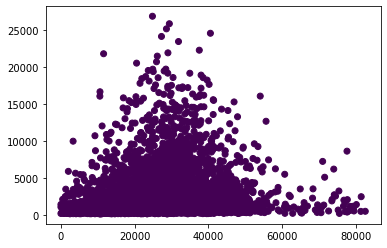

In [900]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
X_train = cluster_data[['inq', 'cluster_size']].values
pipe = Pipeline([('scaler', StandardScaler()), ('db', DBSCAN(eps=1))])
pipe.fit(X_train)
cluster_data['class'] = pipe['db'].labels_
plt.scatter(cluster_data['inq'],	cluster_data['cluster_size'], c=pipe['db'].labels_);

In [784]:
cluster_data

id      lat      lon  cluster  cluster_size           inq   
0         2.0  54.8436  38.1929      0.0        5056.0  26032.644737  \
1         6.0  54.9034  38.0696      0.0         989.0  15146.533333   
2         6.0  54.8933  38.0780      1.0         830.0  39723.665414   
3         8.0  54.8914  38.0634      0.0         569.0      12856.75   
4         8.0  54.8811  38.0551      1.0         241.0  12940.543478   
...       ...      ...      ...      ...           ...           ...   
5397  50558.0  54.8424  38.1937      0.0         755.0    23004.2539   
5398  50558.0  54.8504  38.1727      1.0         686.0  37051.639583   
5399  50617.0  54.8935  38.0661      0.0         537.0  29144.517724   
5400  50913.0  54.8860  38.0905      0.0         518.0  33435.191521   
5401  52006.0  54.8855  38.0870      0.0         836.0  39378.040404   

     wewd_ratio  work_place  class  
0      1.111111        True      0  
1           0.0        True      0  
2      0.208333       False      0  
3           0.0       False      0  
4           0.0       False      0  
...         ...         ...    ...  
5397        0.0        True      0  
5398   1.666667       False      0  
5399      0.625       False      0  
5400      0.625       False      0  
5401       1.25       False      0  

[5370 rows x 9 columns]

<AxesSubplot: >

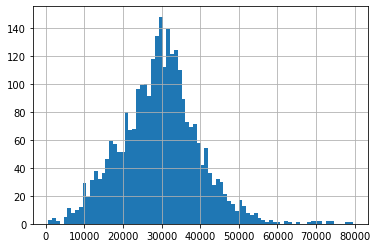

In [988]:
cluster_data['inq'].hist(bins=80)

In [989]:
cluster_data['work_place'].value_counts()

work_place
False    1575
True     1260
Name: count, dtype: int64

In [991]:
filtered_clusters = cluster_data[cluster_data['inq'].between(14000, 53000)]

In [992]:
filtered_clusters

id      lat      lon  cluster  cluster_size           inq   
0         2.0  54.8436  38.1929      0.0        5056.0  26032.644737  \
1         6.0  54.9034  38.0696      0.0         989.0  15146.533333   
2         6.0  54.8933  38.0780      1.0         830.0  39723.665414   
5        13.0  54.8428  38.1908      0.0        2908.0  38369.617647   
6        14.0  54.8419  38.1885      0.0        2213.0   35349.09434   
...       ...      ...      ...      ...           ...           ...   
5355  36014.0  54.8840  38.0581      0.0        1399.0  31713.003268   
5356  36099.0  54.9429  38.0713      0.0        3069.0  28944.586667   
5358  36365.0  54.9423  38.1347      0.0        3963.0   33879.40293   
5363  36721.0  54.8860  38.0891      0.0        2429.0  36563.291667   
5365  37192.0  54.8448  38.1918      0.0        3194.0  33701.266667   

     wewd_ratio  work_place  class  
0      1.111111        True      0  
1           0.0        True      0  
2      0.208333       False      0  
5      1.071429       False      0  
6      0.833333       False      0  
...         ...         ...    ...  
5355   0.909091       False      0  
5356     1.5625       False      0  
5358    0.78125       False      0  
5363   1.428571       False      0  
5365   0.909091       False      0  

[2601 rows x 9 columns]

In [994]:
filtered_clusters['work_place'].value_counts()

work_place
False    1341
True     1260
Name: count, dtype: int64

In [995]:
geometry = [Point(xy) for xy in zip(filtered_clusters['lon'], filtered_clusters['lat'])]
gdf = gpd.GeoDataFrame(filtered_clusters, geometry=geometry, crs=4326)
gdf.explore(categorical=True, column='work_place', cmap=['blue', 'green', 'red', 'orange'])

In [1039]:
cur_id = 2637
cur_id_df = df.query('id == @cur_id and cluster != -1').copy()
data = cur_id_df[(pd.to_datetime(cur_id_df['ts'], unit='s').dt.dayofweek < 5)].copy()
data['day_ts'] = cur_id_df['ts'] % (60 * 60 * 24)
cur_cluster_data = cluster_data[cluster_data['id'] == cur_id]
cur_cluster_data

id      lat     lon  cluster  cluster_size           inq wewd_ratio   
1091  2637.0  54.8812  38.054      0.0        4881.0  27767.109102   1.666667  \

      work_place  class  
1091        True      0

In [1040]:
data.groupby('cluster')['day_ts'].apply(lambda x: np.sum(x.between(A, B)) / x.shape[0])

cluster
0    0.662763
Name: day_ts, dtype: float64

In [1041]:
for cluster in data['cluster'].unique():
    print(cluster, data.groupby(['cluster', 'log_date'])[['length']].sum().stack()[cluster].median())

0 29382.0


In [1042]:
data.groupby(['cluster', 'log_date'])[['length']].sum().stack()

cluster  log_date          
0        2023-01-30  length    25559.0
         2023-01-31  length    39374.0
         2023-02-01  length    59588.0
         2023-02-02  length     7351.0
         2023-02-06  length    48049.0
         2023-02-09  length    22851.0
         2023-02-10  length    29281.0
         2023-02-14  length    38252.0
         2023-02-16  length    29483.0
         2023-02-17  length    26129.0
         2023-02-20  length      619.0
         2023-02-27  length    36610.0
dtype: float64

(0.0, 80000.0)

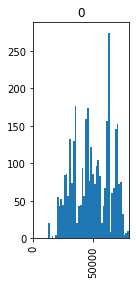

In [1043]:
ax_list = data['day_ts'].hist(layout=(1,3), by=data['cluster'], bins=48)
ax_list[0].set_xlim((0, 80000))
ax_list[1].set_xlim((0, 80000))
ax_list[2].set_xlim((0, 80000))


In [1044]:
cur_id_df.groupby('cluster')['log_date'].nunique()

cluster
0    20
Name: log_date, dtype: int64

In [1045]:
cur_id_df['log_date'].nunique()

20

In [1046]:
geometry = [Point(xy) for xy in zip(cur_cluster_data['lon'],cur_cluster_data['lat'])]
gdf = gpd.GeoDataFrame(cur_cluster_data , geometry=geometry, crs=4326)
gdf.explore(categorical=True, column='work_place', cmap=['blue', 'green', 'red', 'orange'])

In [1030]:
geometry = [Point(xy) for xy in zip(cur_id_df['lon'], cur_id_df['lat'])]
gdf = gpd.GeoDataFrame(cur_id_df, geometry=geometry, crs=4326)
gdf.explore(categorical=True, column='cluster', cmap=['blue', 'green', 'red', 'orange'])